# Terrain Generator

1. HexGrid

2. Terrain

3. Application

4. Test & Small Demo

## Hex Grid

Hexagonal Grid processing. This includes drawing low-level hexagons with `matplotlib`.

The higher-level processing includes adjancency and edge detection.

See:

-  https://www.redblobgames.com/grids/hexagons/	

-  https://www.redblobgames.com/grids/hexagons/#coordinates-doubled

Given hex radius $r$, the size of each hex is given by:

-  $h = \sqrt{3} \times r$

-  $w = 2 \times r$


In [1]:
%matplotlib inline

In [2]:
from collections.abc import Iterator
from functools import cache
from math import sqrt, cos, sin, radians
import random
import string
from typing import Self

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.artist import Artist
from matplotlib.axes import Axes

In [153]:
class HexGrid:
    """
    Defines a tesselation of hexagons.
    
    By definition for 1 cell:

    ..  math::
    
        h = \\sqrt{3} \\times r
    
        w = 2 \\times r

    Coordinates are "doubled grid":
    - even columns have even row cells, 
    - odd columns have odd row cells.

    Given a figure area height of $f_h$ and number of cells, $c$.
    We can compute the number of rows in the figure, $f_r$.
    From this we can compute the radius, $r$ for each hex.
    
    ..  math::

        f_r = \\frac{f_h}{c}
        
        r = \\frac{f_r}{\\sqrt {3}}
        
        r = \\frac{f_r}{\tfrac{1}{2}\\cos(30)}

    This populates **all** the artists: cells, borders, and labels.
    """

    def __init__(self, columns: int, r: float = 1.0) -> None:
        self.columns = columns
        self.rows = 2 * columns
        self.r = r
        self.fill_colors: dict[tuple[int, int], str] = {}
        self.cells: dict[tuple[int, int], Artist] = {}
        self.borders: dict[tuple[int, int], Artist] = {}
        self.labels: dict[tuple[int, int], Artist] = {}
        
    def get_ax(self, fig) -> list[float]:
        fig_height = fig.get_figheight()
        # fig_width = fig.get_figwidth()
        # size = min(fig_width, fig_height) / 2.5
        f_r = fig_height / self.rows
        self.r = round(f_r / sqrt(3), 4)
        # Normal display...
        # bounds = [0, 0, self.columns * 3 * self.r, self.rows * sqrt(3) * self.r]
        # Javascript Animation works really well with [0, 0, 1, 1]
        bounds = [0, 0, 2.0, 2.0]
        self.ax = fig.add_axes(bounds, frameon=False, aspect=1)
        print(f"{fig.get_figwidth()=} {fig.get_figheight()=} {self.r=} {bounds=}")

        for col, row in self.all():
            path = self.hexpath(col, row)
            x = [pt[0] for pt in path] 
            y = [pt[1] for pt in path]
            label = self.cell_name(col, row)
            self.fill_colors[col, row] = "w"
            self.cells[col, row] = self.ax.fill(x, y, self.fill_colors[col, row])
            self.borders[col, row] = self.ax.plot(x, y, '-k', lw=.75)
            x = self.r * 3/2 * col
            y = self.r * sqrt(3)/2 * row
            self.labels[col, row] = self.ax.text(
                x + self.r, y + self.r/2, 
                label, 
                family='sans-serif', size='large', color="tab:gray",
                horizontalalignment='center'
            )
        return self.ax

    @cache
    def hexpath(self, col: int, row: int) -> list[tuple[float, float]]:
        """
        Coordinates of hex vertices.

        >>> hg = HexGrid(4)
        >>> hg.r = 1.0
        >>> hg.hexpath(2, 2)
        [(5.0, 2.73205), (4.5, 3.59808), (3.5, 3.59808), (3.0, 2.73205), (3.5, 1.86603), (4.5, 1.86603), (5.0, 2.73205)]
        """
        x_o = self.r * 3/2 * col + self.r
        y_o = self.r * sqrt(3)/2 * row + self.r
        path = []
        for side in range(0, 6):
            theta = radians(60 * side)
            x = round(cos(theta) * self.r + x_o, 5)
            y = round(sin(theta) * self.r + y_o, 5)
            path.append((x, y))
        path.append(path[0])
        return path

    def all(self) -> Iterator[tuple[int, int]]:
        """
        Enumerate all the cell coordinates.
        
        >>> hg = HexGrid(3)
        >>> [hg.cell_name(*c) for c in hg.all()]
        ['1A', '1C', '1E', '2B', '2D', '2F', '3A', '3C', '3E']
        """
        for col in range(self.columns):
            for row in range(col % 2, self.rows, 2):
                yield col, row

    def paint(self, col: int, row: int, fill: str | None = None):
        """
        Update a hex's fill.
        """
        self.fill_colors[col, row] = fill
        for a in self.cells[col, row]:
            a.set(
                fill=True,
                color=fill
            )
        
    def random(self) -> tuple[int, int]:
        """
        Random cell; if x is odd, y is constrained to odd values.
        """
        x = random.randint(0, self.columns-1)
        y = random.choice(range(x%2, self.rows, 2))
        return (x, y)

    @staticmethod
    def cell_name(col: int, row: int) -> str:
        """
        Cell name using numbers across and letters down.
        
        Note that this is places 1A at the bottom left, when it's often at the top left.
        
        >>> hg = HexGrid(4)
        >>> hg.cell_name(0, 0)
        '1A'
        >>> hg.cell_name(1, 1)
        '2B'
        >>> hg.cell_name(4, 0)
        '5A'
        >>> hg.cell_name(4, 4)
        '5E'
        """
        letter1, letter2 = divmod(row, 26)
        if letter1 == 0:
          row_label = string.ascii_uppercase[letter2]
        else:
          row_label = string.ascii_uppercase[letter1-1] + string.ascii_uppercase[letter2]
        return f"{col+1}{row_label}"

    @staticmethod
    def adjacent(col: int, row: int, direction: int) -> tuple[int, int]:
        """
        See https://www.redblobgames.com/grids/hexagons/#neighbors-doubled
        
        direction is 0 to 5.
        
        >>> base = (2, 2)
        >>> [HexGrid.adjacent(*base, d) for d in range(6)]
        [(3, 3), (3, 1), (2, 0), (1, 1), (1, 3), (2, 4)]
        >>> [HexGrid.cell_name(*HexGrid.adjacent(*base, d)) for d in range(6)]
        ['4D', '4B', '3A', '2B', '2D', '3E']
        """
        doubleheight_directions = [
          (+1, +1), (+1, -1), ( 0, -2), 
          (-1, -1), (-1, +1), ( 0, +2), 
        ]
        x_d, y_d = doubleheight_directions[direction]
        return col+x_d, row+y_d
    
    @cache
    def edge(self, x: int, y: int) -> bool:
        """
        On the outside edge?
        
        >>> hg = HexGrid(4)
        
        # Row numbers is double, but alternating grid means there's only really 4 rows.
        >>> hg.rows
        8
        
        # Columns defines the width in a square space
        >>> hg.columns
        4
        
        >>> hg.edge(0, 0)
        True
        >>> hg.edge(1, 3)
        False
        >>> hg.edge(4, 4)
        False
        >>> hg.edge(3, 7)
        True
        """
        left_right = x == 0 or x == self.columns-1
        top_bottom = (y == 0 or y == self.rows-2) if x%2 == 0 else (y==1 or y == self.rows-1)
        return top_bottom or left_right

    @cache
    def within(self, x: int, y: int) -> bool:
        """
        Within the hexgrid generally?
        
        >>> hg = HexGrid(4)
        >>> hg.within(0, 0)
        True
        >>> hg.within(-1, 3)
        False
        >>> hg.within(3, 7)
        True
        >>> hg.within(4, 8)
        False
        """
        left_right = (0 <= x <= self.columns-1)
        top_bottom = (0 <= y <= self.rows-2) if x%2 == 0 else (1 <= y <= self.rows-1)
        inside = top_bottom and left_right
        # print(f"within({x}, {y}) -> {inside}")
        return inside
      

## Terrain

Paint random cells of the hexgrid.

The idea is to evolve toward an Empire of Cities and build out the country surrounding each capital city incrementally to allow interesting borders to evolve.

In [154]:
class City:
    """
    A central "location" surrounded by a "domain".
    
    >>> hg=HexGrid(4)
    >>> c = City(hg, 'test', "tab:red")
    >>> c.name
    'test'
    >>> c.city_color
    '#d62728'
    >>> c.terrain_color
    '#e26161'
    >>> c.place(2, 2)
    >>> c.location
    (2, 2)
    >>> c.domain
    {(2, 4), (3, 1), (1, 1), (2, 0), (3, 3), (1, 3)}
    >>> repr(c)
    'test-3C'
    >>> (3, 3) in c.occupies()
    True
    >>> (4, 4) in c.occupies()
    False
    >>> sorted(c.border())
    [(0, 0), (0, 2), (0, 4), (1, -1), (1, 5), (2, -2), (2, 2), (2, 6), (3, -1), (3, 5), (4, 0), (4, 2), (4, 4)]
    """
    
    def __init__(self, hexgrid: HexGrid, name: str, color: str) -> None:
        self.hg = hexgrid
        self.name = name
        shift = 0.30  # 30% lighter.
        rgb = mcolors.to_rgb(mcolors.get_named_colors_mapping()[color])
        self.city_color = mcolors.to_hex(rgb)
        self.terrain_color = mcolors.to_hex(mcolors.hsv_to_rgb(mcolors.rgb_to_hsv(rgb) * [1.0, (1-shift), (1-shift)] + [0.0, 0.0, shift]))
        self.location: tuple[int, int] | None = None
        self.domain: set[tuple[int, int]] = set()
    
    def __repr__(self):
        return f"{self.name}-{self.hg.cell_name(*self.location)}"
    
    __str__ = __repr__
    
    def place(self, x: int, y: int) -> None:
        self.location = (x, y)
        self.domain = {self.hg.adjacent(x, y, d) for d in range(6)}
    
    def add(self, x: int, y: int) -> None:
        self.domain.add((x, y))
    
    def occupies(self) -> set[tuple[int, int]]:
        return set(self.domain) | {self.location}
    
    def border(self) -> set[tuple[int, int]]:
        """All cell(s) adjacent to the city's domain"""
        # candidates = set()
        # for d in self.domain:
        #    candidates |= set(self.hg.adjacent(*d, dir) for dir in range(6))
        candidates = set(
            self.hg.adjacent(*d, dir)
            for d in self.domain
            for dir in range(6)
        )
        final_locations = candidates - set(self.domain)
        return final_locations
          
    def paint(self) -> None:
        # print(f"City {self.city_color} at {self.hg.cell_name(*self.location)} = {self.location}")
        self.hg.paint(*self.location, fill=self.city_color)
        for terrain in self.domain:
            self.hg.paint(*terrain, fill=self.terrain_color)


In [155]:
class Empire:
    """
    A collection of Cities.
    
    >>> hg = HexGrid(4)
    >>> e = Empire(hg)
    >>> c = City(hg, 'test', "tab:blue")
    >>> random.seed(42)
    >>> e.add_city(c)
    >>> sorted(e.occupied())
    [(1, 1), (1, 3), (2, 0), (2, 2), (2, 4), (3, 1), (3, 3)]
    """
    def __init__(self, hexgrid):
        self.hg = hexgrid
        self.cities = []
    
    def add_city(self, city: City) -> None:
        x, y = self.hg.random()
        while self.hg.edge(x, y):
              x, y = self.hg.random()
        while not self.hg.edge(x, y) and (x,y) in {c.location for c in self.cities}:
              x, y = self.hg.random()
        city.place(x, y)
        self.cities.append(city)
    
    def occupied(self) -> list[tuple[int, int]]:
        occ = set()
        for c in self.cities:
          occ.add(c.location)
          occ |= set(c.domain)
        return occ
    
    def paint(self) -> None:
        for c in self.cities:
            c.paint()


In [156]:
COLORS = [
  "tab:red", "tab:purple", "tab:blue", "tab:green", "tab:olive"
]

def generate(hexgrid: HexGrid, seed: int, generations: int = 48) -> Empire:
    random.seed(seed)
    empire = Empire(hexgrid)
    # Plant the initial cities.
    for i in range(5):
        _, name = COLORS[i].split(":")
        c = City(hexgrid, name, COLORS[i])
        empire.add_city(c)
    # Initial
    yield empire
    
    # Expand each city through 48 adjacent cells. (Why 48? 48*5=240, grid is 18x14 = 252, 95% is the target
    # Inefficient algorithm recomputes border - occupied each time. Should simply add the new to city and occupied.
    for i in range(generations):
        # print(f"Generation {i}")
        occupied = empire.occupied()
        for c in empire.cities:
            expansion = c.border()
            expansion -= occupied
            if expansion:
                new = random.choice(list(expansion))
                if hexgrid.within(*new):
                    # print(f"Expand {c} to {new}")
                    c.add(*new)
                    occupied |= {new}
            else:
                pass
                # print(f"No Expansion for {c}")
        yield empire

    # Fill simple holes: they're surrounded by one color
    holes = set(hexgrid.all())  # Refactor into Empire class
    for c in empire.cities:
        holes -= c.occupies()
        
    for h in holes:
        # print(f"\nfilling hole {hexgrid.cell_name(*h)}")
        neighbors = []
        for c in empire.cities:
            adjacent = [d for d in range(6) if hexgrid.adjacent(*h, d) in c.occupies()]
            if len(adjacent) == 6:
                neighbors.append((c, len(adjacent)))
            else:
                # Partial Coverage
                neighbors.append((c, len(adjacent)))

        # Hole is (almost) fully surrounded...
        if sum(cells for city, cells in neighbors) >= 5:
            # May be some dispute here, we resolve it with a random choice.
            # TODO: Disputes get blended color and a fill pattern.
            assigned_city = random.choice([city for city, cells in neighbors if cells != 0])
            assigned_city.add(*h)
        else:
            # Incomplete surround. (May be two adjacent holes.)
            # report = [f"{city!r} {cells}" for city, cells in partial if cells != 0]
            # print(f"Multi-Surround {hexgrid.cell_name(*h)}:  {', '.join(report)}")
            pass

    # Final
    yield empire

## Applications

Ideally, we want animation.

There are two approaches.

In the final analysis, we only want the map. So we have that, also.

In [157]:
# Doesn't work inline in JupyterLab.
# This is more suitable for a stand-alone Tk app.
# https://matplotlib.org/stable/gallery/user_interfaces/embedding_in_tk_sgskip.html

def show_empire_1(seed: int, generations: int = 48) -> Empire:
    hexgrid = HexGrid(18)
    fig = plt.figure(figsize=(4.0, 4.0))
    ax = hexgrid.get_ax(fig)
    with plt.ion():
        for empire in generate(hexgrid, seed, generations):
            empire.paint()
            plt.pause(0.10)
    plt.show()
    return empire

In [158]:
# This interactive mode doesn't work in JupyterLab.

# e = show_empire_1(42)


In [159]:
# FuncAnimation...

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

class EmpireAnimation:
    def __init__(self, seed: int, generations: int = 48) -> None:
        self.hexgrid = HexGrid(18)
        self.fig = plt.figure()
        self.ax = self.hexgrid.get_ax(self.fig)
        self.last: Empire | None = None

        # Very important to NOT create a list; then the shared mutable Empire object is in its final state.
        self.sequence = iter(generate(self.hexgrid, seed, generations))

    def start(self):
        return list(self.hexgrid.borders.values()) + list(self.hexgrid.labels.values())
        
    def __call__(self, frame: int):
        try:
            empire = next(self.sequence)
            self.last = empire
            empire.paint()
            return list(self.hexgrid.cells.values())
        except StopIteration:
            return []


def show_empire_2(seed: int, generations: int = 48) -> Empire:
    update = EmpireAnimation(seed, generations)
    animation = FuncAnimation(fig=update.fig, func=update, init_func=update.start, frames=generations+2, interval=200)

    # Option 1 -- save as HTML
    # PNG Frames are empty...
    # Path("empire.html").unlink()
    # animation.save("empire.html", writer="html")
    # print("Saved to empire.html")

    # Option 2 -- inline JavaScript Animation.
    # Frames are all empty... 
    display(HTML(animation.to_jshtml(default_mode='loop')))
    
    return update.last

In [160]:
0.077 * sqrt(3) * 18

2.400622419290464

fig.get_figwidth()=6.4 fig.get_figheight()=4.8 self.r=0.077 bounds=[0, 0, 2.0, 2.0] 


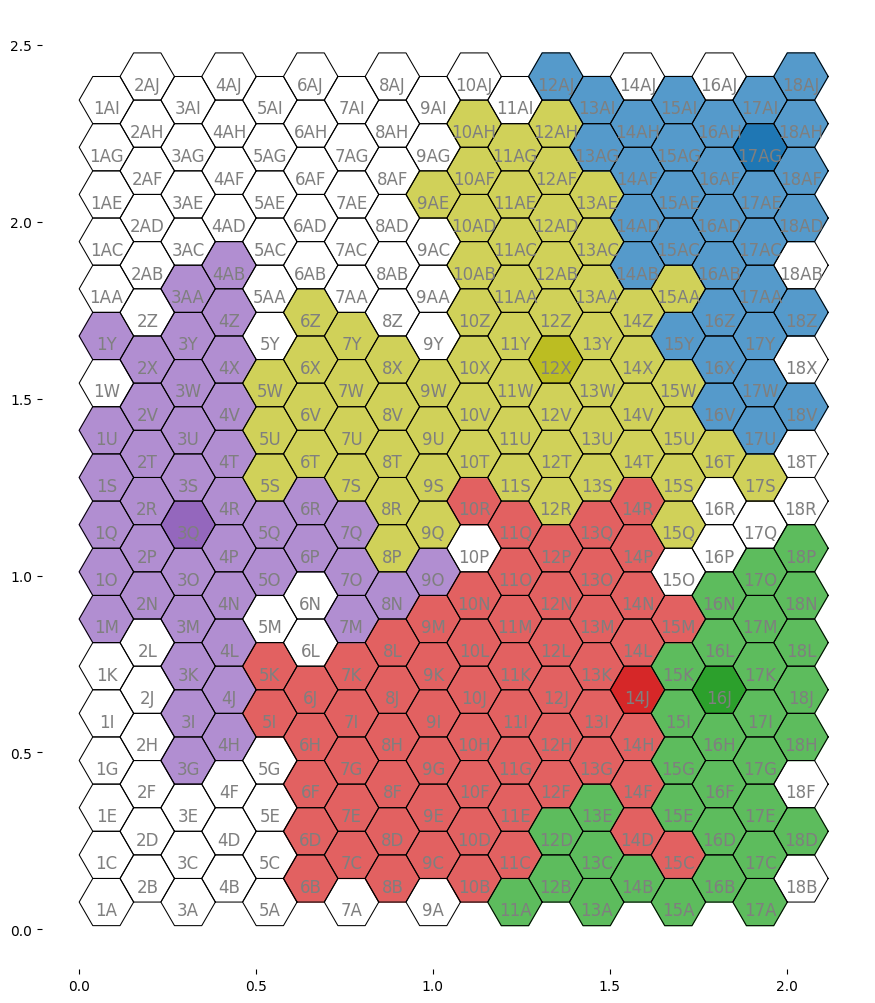

In [161]:
e = show_empire_2(12991971503914480054)


### Option 3: show the final map, skipping past the build steps.

In [162]:
def show_empire_3(seed: int, generations: int = 48) -> Empire:
    hexgrid = HexGrid(18)
    sequence = list(generate(hexgrid, seed, 48))
    empire = sequence[-1]
    
    fig = plt.figure(figsize=(6.0, 6.0))
    ax = hexgrid.get_ax(fig)
    empire.paint()
    plt.axis('off')
    plt.show()

fig.get_figwidth()=6.0 fig.get_figheight()=6.0 self.r=0.0962 bounds=[0, 0, 2.0, 2.0] 


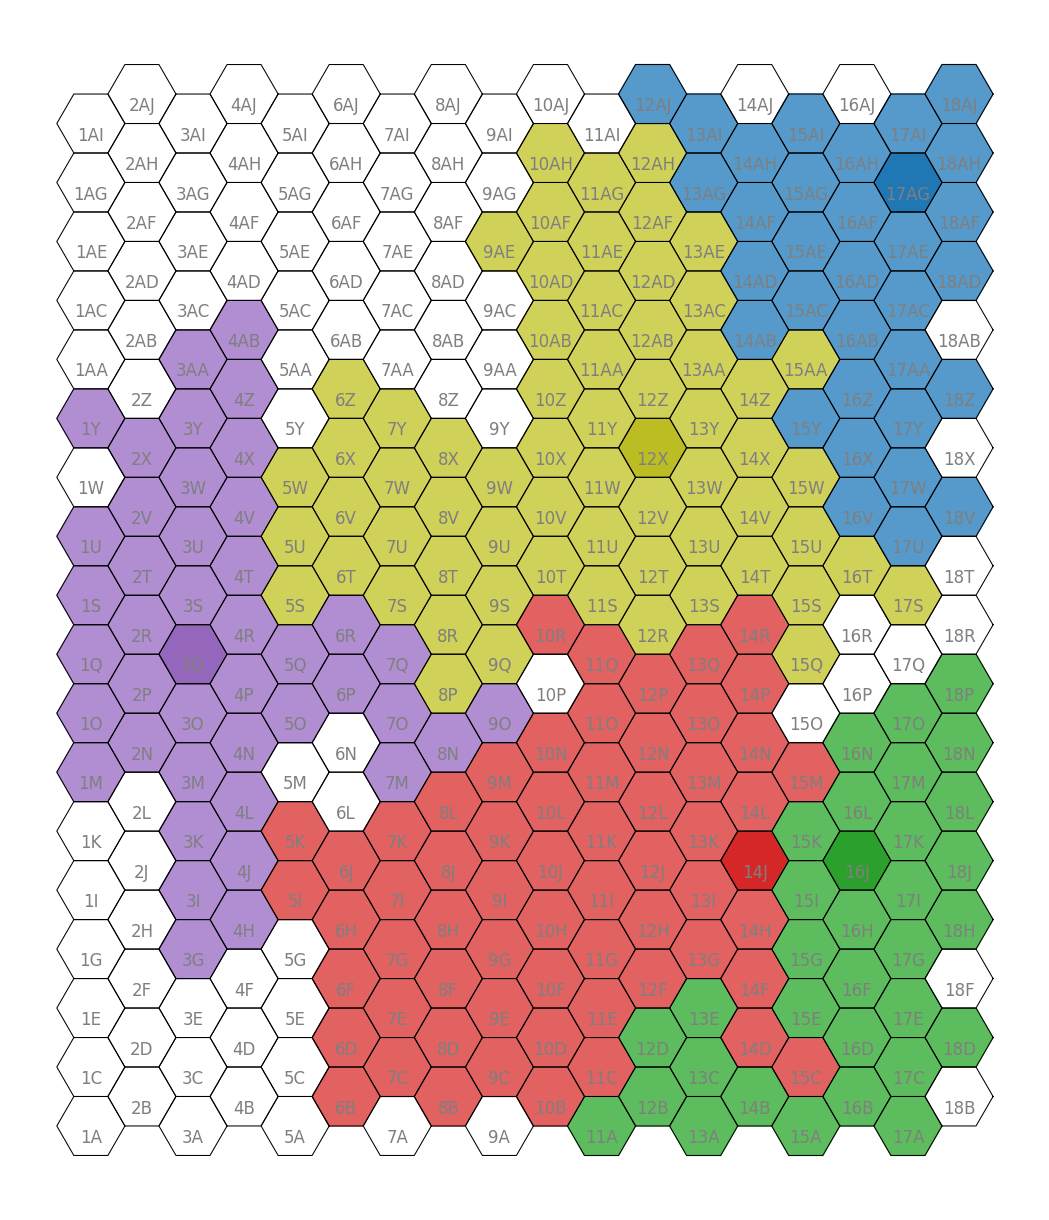

In [163]:
show_empire_3(seed = 12991971503914480054)

## Test

In [29]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=43)

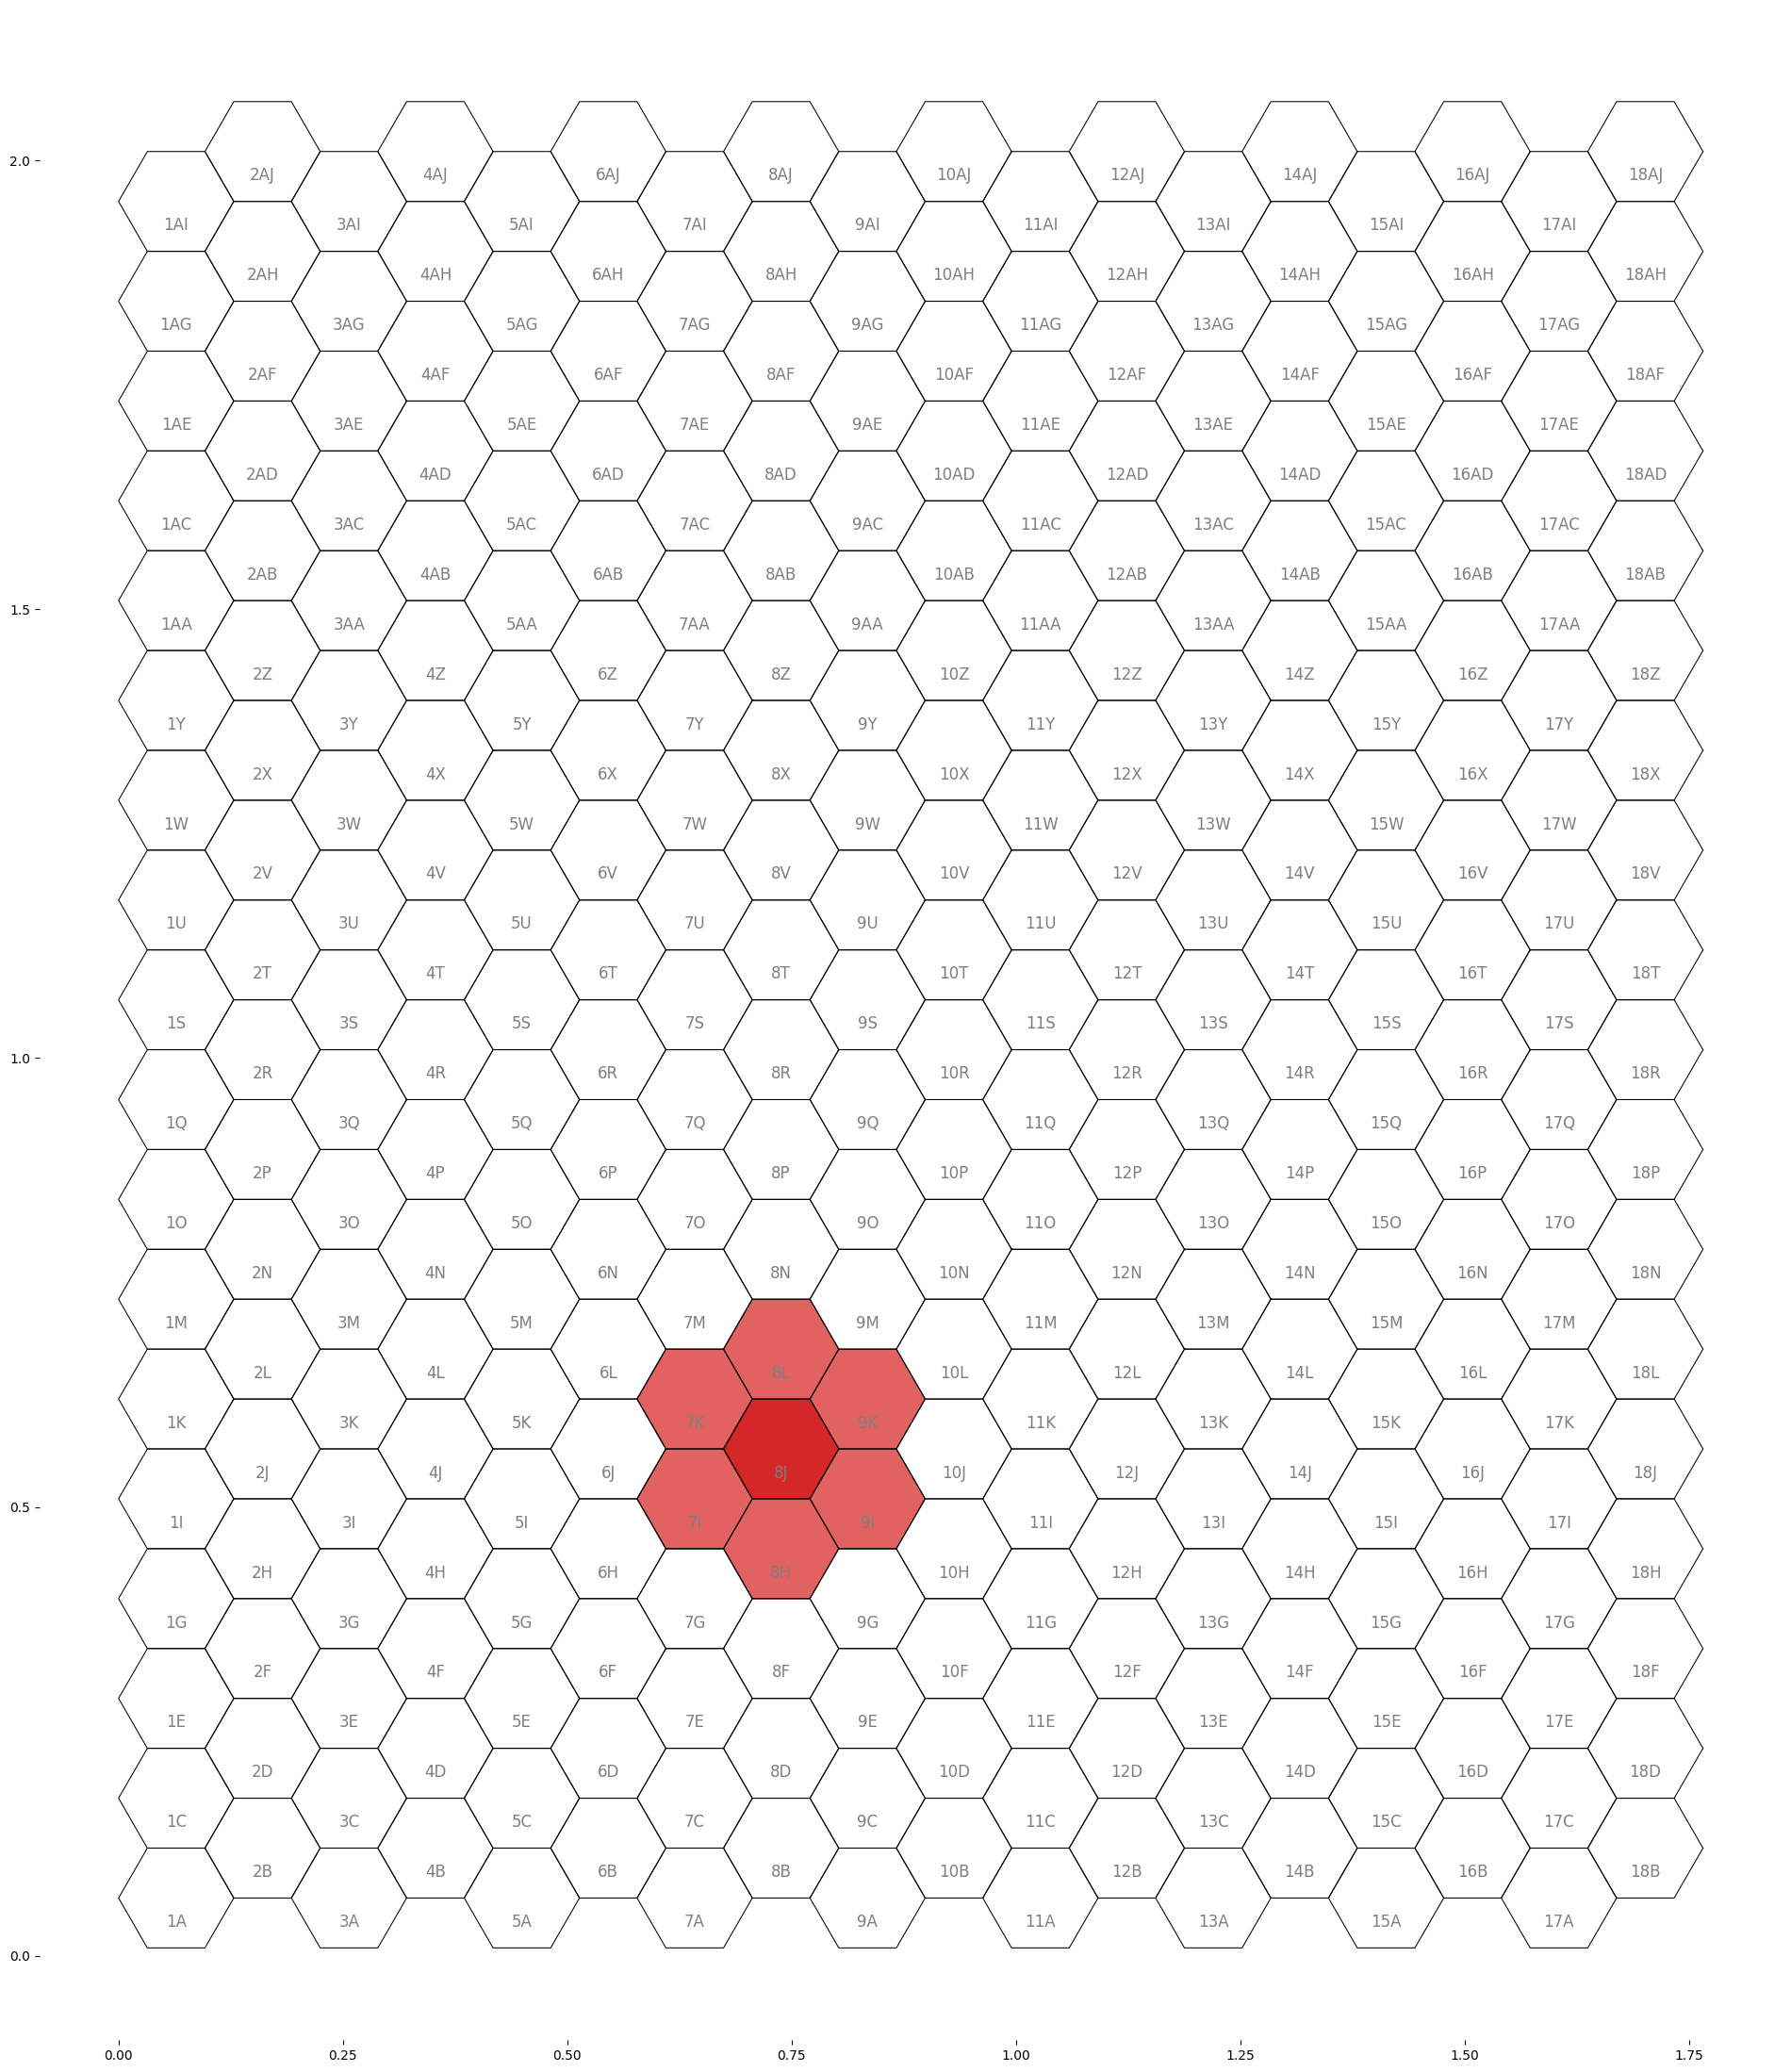

In [31]:
fig = plt.figure(figsize=(8.0, 8.0))
hg = HexGrid(18)
ax = hg.get_ax(fig)
c = City(hg, "Red", "tab:red")
x, y = hg.random()
c.place(x, y)
c.paint()
plt.show()

In [ ]:
c